In [1]:
import numpy as np
from sklearn import linear_model
import pickle
import matplotlib.pyplot as plt
import itertools

### Experiments with Simulated Data
Suppose we have $n=100$ training data points and another $50$ testing data points

Discrete Variables $X={X_1,X_2,X_3,X_4}$; $X_i \in \{0,1\}$; $X\in \mathcal{R}^{n\times 4}$

Continous Variable $\mathbf{z}$; $\mathbf{z} \in \mathcal{R}^{n \times 1}$

Continous Target Variable $\mathbf{y}$; $\mathbf{y} \in \mathcal{R}^{n \times 1}$

True Moderator Variable $X_1,X_2$

Data generated :
    $$y = z\beta_i+b_i+\epsilon$$

#### Generating simulation data

In [10]:
probs = np.array([0.4,0.6,0.5])
n = 10**6
for i,k in enumerate(itertools.product([0,1],repeat=len(probs))):
    l = np.prod(probs**np.array(k))*np.prod((1-probs)**(1-np.array(k)))*n+1e-6
    l = int(l)
    if i==0:X = np.tile(np.array(k),(l,1))
    else:X = np.vstack([X,np.tile(np.array(k),(l,1))])

print X.shape
X = X[np.random.permutation(n)]
# probs = [0.4,0.6,0.4,0.6]
# n = 150
# X = np.zeros((n,4))
# for i,p in enumerate(probs):
#     X[:,i]=np.array([np.random.binomial(1,p) for j in range(n)])
z = np.random.randn(n).reshape(n,1)
y = np.zeros(n)
beta = np.random.randn(4,2)*2
print beta
X = np.hstack([X,z])

(1000000, 3)
[[-0.19944129  0.53528902]
 [-5.30204814  3.14334759]
 [-1.67857607 -1.94183639]
 [-0.88784948 -2.75667022]]


In [11]:
# y = z*beta_0+beta_1

for i in range(n):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = beta[0][0]*z[i]+beta[0][1]
        else: y[i] = beta[1][0]*z[i]+beta[1][1]
    else:
        if X[i][1]==0: y[i] = beta[2][0]*z[i]+beta[2][1]
        else: y[i] = beta[3][0]*z[i]+beta[3][1]
# add noise
print X.shape,beta
y = y+np.random.randn(n)*0.5
train_X = X
train_y = y
test_X = X
test_y = y

(1000000, 4) [[-0.19944129  0.53528902]
 [-5.30204814  3.14334759]
 [-1.67857607 -1.94183639]
 [-0.88784948 -2.75667022]]


In [12]:
# with open('data.pkl','w') as f:
#     pickle.dump((features,y),f)
# with open('coeff.pkl','w') as f:
#     pickle.dump(beta,f)

In [92]:
# fit linear regression with given features 
def lr(features,train_X,train_y,test_X,test_y):

    model = linear_model.LinearRegression(fit_intercept=True)
    features = np.array(list(features))
    n_feature =len(features)
    train_err = 0.0
    test_err = 0.0
    train_vector =np.sum(train_X[:,features]* np.array([2**i for i in range(n_feature)]),axis=1)
    test_vector =np.sum(test_X[:,features]* np.array([2**i for i in range(n_feature)]),axis=1)
    train_X = train_X[:,-1].reshape(-1,1)
    test_X = test_X[:,-1].reshape(-1,1)
    for v in range(2**n_feature):
        train_idx = np.where(train_vector==v)[0]
        test_idx = np.where(test_vector==v)[0]
        model.fit(train_X[train_idx],train_y[train_idx])
        train_err += np.sum((model.predict(train_X[train_idx])-train_y[train_idx])**2)
        if len(test_idx)!=0:
            test_err += np.sum((model.predict(train_X[test_idx])-test_y[test_idx])**2)
    return train_err/len(train_y),test_err/len(test_y)
# print lr(set([2]),train_X,train_y,test_X,test_y)

In [15]:
violation = False
v = 0
t =0
for i in range(1):
    s_y = list(itertools.combinations(np.arange(3),i+2))
    for s in s_y:
        s_x = list(itertools.combinations(s,i+1))
        comp = set(np.arange(4)).difference(set(s))
        for sub_s_x in s_x:
            for c in comp:
                t+=1
                s = set(s)
                sub_s_x = set(sub_s_x )
                print 'X = {}; Y={}; x = {}'.format(sub_s_x,s,c)
                train_err1 = lr(s,train_X,train_y,test_X,test_y)[0]
                train_err2 = lr(sub_s_x,train_X,train_y,test_X,test_y)[0]
                s.add(c)
                sub_s_x.add(c)
                print train_err1 - lr(s,train_X,train_y,test_X,test_y)[0],\
                train_err2 - lr(sub_s_x,train_X,train_y,test_X,test_y)[0]
                if train_err1 - lr(s,train_X,train_y,test_X,test_y)[0]<train_err2 - lr(sub_s_x,train_X,train_y,test_X,test_y)[0]:
                    violation = True
                    if violation: v+=1
                s.remove(c)
                sub_s_x.remove(c)
                break
    
print violation,v,t

X = set([0]); Y=set([0, 1]); x = 2
2.13107079086e-06 4.92191024817e-05
X = set([1]); Y=set([0, 1]); x = 2
2.13107079086e-06 4.29015862267e-05
X = set([0]); Y=set([0, 2]); x = 1
4.85219288448 4.85223997251
X = set([2]); Y=set([0, 2]); x = 1
4.85219288448 2.18828341703
X = set([1]); Y=set([1, 2]); x = 0
8.59559177847 8.59563254899
X = set([2]); Y=set([1, 2]); x = 0
8.59559177847 5.93168231102
True 4 6


#### Greedy Algorithm

0.252525433103 0.252525433103
[  1.29609440e+01   4.41534070e+00   3.07554629e-04   3.50190147e-04]


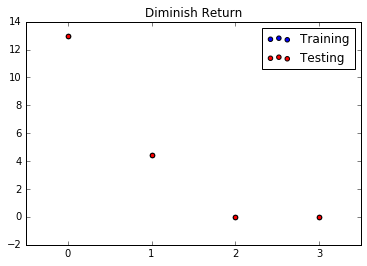

In [37]:
train_r = np.zeros(4)
test_r = np.zeros(4)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
for i,s in enumerate(feature_set):
    feature_set.remove(s)
    train_err1,test_err1=lr(feature_set,train_X,train_y,test_X,test_y)
    train_r[i] = train_err1-train_err
    test_r[i] = test_err1-test_err
    feature_set.add(s)
print train_r
plt.scatter(np.arange(4),train_r,label='Training')
plt.scatter(np.arange(4),test_r,label = 'Testing',c = 'red')
plt.xticks(np.arange(4),np.arange(4))
plt.title('Diminish Return')
plt.legend()
plt.show()

#### Remove feature according to the diminish return

0.252525433103 0.252525433103


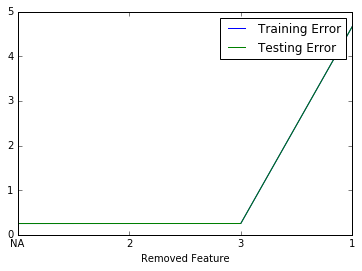

In [38]:
rm_order = np.argsort(train_r)
lr_train_err = np.zeros(4)
lr_test_err = np.zeros(4)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
lr_train_err[0] = train_err
lr_test_err[0] = test_err
for i,s in enumerate(rm_order[:-1]):
    feature_set.remove(s)
    train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
    lr_train_err[i+1] = train_err 
    lr_test_err[i+1] = test_err
plt.plot(np.arange(4),lr_train_err,label='Training Error')
plt.plot(np.arange(4),lr_test_err,label = 'Testing Error')
plt.xticks(np.arange(4),np.hstack(['NA',rm_order]))
plt.xlabel('Removed Feature')
plt.legend()
plt.show()

#### Lasso

In [40]:
def inter_terms(n,X):
    inds = list(itertools.product([0,1],repeat=n))
    ind_term = np.array(['X'+str(i+1) for i in range(6)])
    terms = []
    for i in inds:
        terms.append(''.join(ind_term[np.nonzero(np.array(i))[0]]))    
        Xprod = np.prod(X[:,np.nonzero(np.array(i))[0]],axis=1)
        X = np.hstack([X,Xprod.reshape(-1,1)])
    return X,terms[1:]
train_X,terms = inter_terms(6,train_X)
test_X,terms = inter_terms(6,test_X)

In [41]:
alphas = np.linspace(0.01,0.5,10)
train_err = []
test_err = []
coeffs = []
for a in alphas:
    model = linear_model.Lasso(alpha=a)
    model.fit(train_X,train_y)
    train_err.append(np.mean((model.predict(train_X)-train_y)**2))
    test_err.append(np.mean((model.predict(test_X)-test_y)**2))    
    coeffs.append(model.coef_)

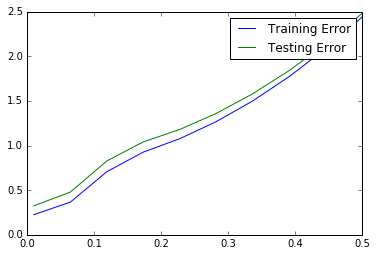

In [42]:
plt.plot(alphas,train_err,label = 'Training Error')
plt.plot(alphas,test_err,label='Testing Error')
plt.legend()
plt.show()

In [43]:
terms = np.array(terms)
for coeff in coeffs:
    print terms[np.nonzero(coeff)[0]]

['X6' 'X5' 'X1X4X5X6' 'X1X3' 'X1X3X5' 'X1X3X5X6' 'X1X2X4X5X6']
['X6' 'X5' 'X1X4X5X6' 'X1X2X4X5X6']
['X6' 'X5' 'X2X4X5X6' 'X1X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X2X4X5X6' 'X1X2X4X5X6']
['X5' 'X1X2X4X5X6']


### Fit with MMR 
#### True model(including $X_1,X_2$ as moderator):
$$y = w_0 X_1+w_1 X_2+w_2Z+w_3ZX_1+w_4ZX_2+w_5ZX_1X_2+b+\epsilon$$

In [31]:
from sklearn.linear_model import LinearRegression as lr
import matplotlib.pyplot as plt

In [50]:
with open('data.pkl','r') as f:
    D,y = pickle.load(f)
with open('coeff.pkl','r') as f:
    true_coeff = pickle.load(f)
print true_coeff

[[-1.80749167  1.74274824]
 [ 1.83346927  2.50955861]
 [-3.65056916 -1.61338262]
 [ 0.29304958 -1.32141819]]


In [67]:
#### Reformat data
X = np.vstack([D[:,0],D[:,1],D[:,4],D[:,4]*D[:,0],D[:,4]*D[:,1],D[:,4]*D[:,0]*D[:,1]]).T
print X.shape

(150, 6)


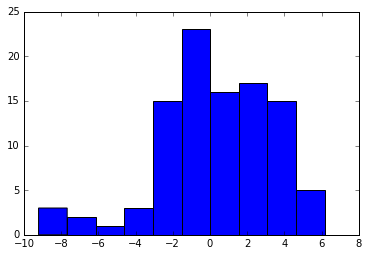

In [71]:
train_X = X[:100]
test_X = X[100:]
train_y = y[:100]
test_y = y[100:]
plt.hist(train_y)
plt.show()

In [74]:
model = lr()
model.fit(train_X,train_y)
print 'Baseline(sample mean):  {}'.format(np.mean((test_y-np.ones(50)*np.mean(train_y))**2))
print 'Training error:  {}'.format(np.mean((model.predict(train_X)-train_y)**2))
print 'Testing error:  {}'.format(np.mean((model.predict(test_X)-test_y)**2))

Baseline(sample mean):  6.27526373319
Training error:  0.206913093859
Testing error:  0.239249720806


### Fit with Multiple Linear Regression (including $Xs = {X_1,X_2,X_3,X_4}$ as moderator)
We see MLR is overfitting since we include too many features

In [75]:
from itertools import product

In [127]:
inds = list(product([0,1],repeat=4))

In [112]:
# introducint product terms
X = np.copy(D[:,:4])
for i in inds:
    Xprod = np.prod(D[:,np.nonzero(np.array(i))[0]],axis=1)
    X = np.hstack([X,(D[:,-1]*Xprod).reshape(-1,1)])

(150, 20)


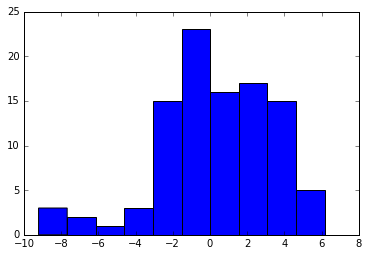

In [113]:
train_X = X[:100]
test_X = X[100:]
train_y = y[:100]
test_y = y[100:]
plt.hist(train_y)
plt.show()

If we include all $X_i$ as indicators, we see multiple linear regression(MLR) is **overfitting** 

since testing error is almost **twice** as large as training error 

In [114]:
model = lr()
model.fit(train_X,train_y)
print 'Baseline(sample mean):  {}'.format(np.mean((test_y-np.mean(train_y))**2))
print 'Training error:  {}'.format(np.mean((model.predict(train_X)-train_y)**2))
print 'Testing error:  {}'.format(np.mean((model.predict(test_X)-test_y)**2))

Baseline(sample mean):  6.27526373319
Training error:  0.170143148904
Testing error:  0.33116661003


### Fit with Lasso (including $Xs = {X_1,X_2,X_3,X_4}$ as moderator)

In [115]:
from sklearn import linear_model

In [143]:
alphas = np.linspace(0.01,0.5,10)
train_err = []
test_err = []
coeffs = []
for a in alphas:
    model = linear_model.Lasso(alpha=a)
    model.fit(train_X,train_y)
    train_err.append(np.mean((model.predict(train_X)-train_y)**2))
    test_err.append(np.mean((model.predict(test_X)-test_y)**2))    
    coeffs.append(model.coef_)

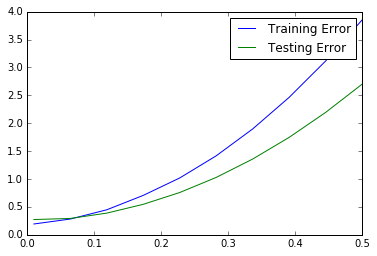

In [144]:
plt.plot(alphas,train_err,label = 'Training Error')
plt.plot(alphas,test_err,label='Testing Error')
plt.legend()
plt.show()

In [151]:
terms = np.array(['X1','X2','X3','X4','Z','ZX4','ZX3','ZX3X4',\
        'ZX2','ZX2X4','ZX2X3','ZX2X3X4',\
        'ZX1','ZX1X4','ZX1X3','ZX1X3X4',\
        'ZX1X2','ZX1X2X4','ZX1X2X3','ZX1X2X3X4'])
print 'nonzero product terms:'
for coeff in coeffs:
    print terms[np.nonzero(coeff)[0]]

nonzero product terms:
['X1' 'X2' 'X4' 'Z' 'ZX2' 'ZX2X3X4' 'ZX1' 'ZX1X4' 'ZX1X3' 'ZX1X2' 'ZX1X2X4'
 'ZX1X2X3X4']
['X1' 'X2' 'X4' 'Z' 'ZX2' 'ZX1']
['X1' 'X2' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']
['X1' 'Z' 'ZX2' 'ZX1']


#### Diminish Return Test for Submodularity 
$f(X \cup \{x\})-f(X)\geq f(Y \cup \{x\})-f(Y)\quad \text{if } X\subseteq Y\quad x\in \Omega \setminus Y$

In [97]:
# Data generation
# Xi ~ Ber(n,pi)

probs = np.array([0.5,0.4,0.6,0.4,0.7,0.3])
n = 10**5
s = 0
f = 0
for i,k in enumerate(itertools.product([0,1],repeat=len(probs))):
    l = np.prod(probs**np.array(k))*np.prod((1-probs)**(1-np.array(k)))*n+1e-6
    f+=l
    l = int(l)
    s+=l
    if i==0:X = np.tile(np.array(k),(l,1))
    else:X = np.vstack([X,np.tile(np.array(k),(l,1))])
print X.shape
X = X[np.random.permutation(n)]

beta = np.random.randn(4,2)*2
y = np.zeros(n)
for i in range(n):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = sum(beta[0][:2]*X[i][:2])+beta[0][1]
        else: y[i] = sum(beta[1][:2]*X[i][:2])+beta[1][1]
    else:
        if X[i][1]==0: y[i] = sum(beta[2][:2]*X[i][:2])+beta[2][1]
        else: y[i] = sum(beta[3][:2]**X[i][:2])+beta[3][1]
# add noise e~N(0,0.5^2)
y = y+np.random.randn(n)*0.5
train_X = X#[:int(n*0.8)]
test_X = X#[int(n*0.8):]
train_y = y#[:int(n*0.8)]
test_y = y#[int(n*0.8):]


(100000, 6)


In [100]:
violation = False
for i in range(1,4):
    s_y = list(itertools.combinations(np.arange(6),i+2))
    for s in s_y:
        s_x = list(itertools.combinations(s,i+1))
        comp = set(np.arange(6)).difference(set(s))
        for sub_s_x in s_x:
            for c in comp:
                s = set(s)
                sub_s_x = set(sub_s_x )
                print 'X = {}; Y={}; x = {}'.format(sub_s_x,s,c)
                train_err1 = lr(s,train_X,train_y,test_X,test_y)[0]
                train_err2 = lr(sub_s_x,train_X,train_y,test_X,test_y)[0]
                s.add(c)
                sub_s_x.add(c)
                print train_err1 - lr(s,train_X,train_y,test_X,test_y)[0],\
                  train_err2 - lr(sub_s_x,train_X,train_y,test_X,test_y)[0]
                if train_err1 - lr(s,train_X,train_y,test_X,test_y)[0]<train_err2 - lr(sub_s_x,train_X,train_y,test_X,test_y)[0]:
                    violation = True
                s.remove(c)
                sub_s_x.remove(c)
print violation

X = set([0, 1]); Y=set([0, 1, 2]); x = 3
1.77227286642e-05 1.07187107628e-05
X = set([0, 1]); Y=set([0, 1, 2]); x = 4
2.50321215367e-05 8.44258762428e-06
X = set([0, 1]); Y=set([0, 1, 2]); x = 5
2.4126521731e-05 1.21951469684e-05
X = set([0, 2]); Y=set([0, 1, 2]); x = 3
1.77227286642e-05 8.76982397813e-06
X = set([0, 2]); Y=set([0, 1, 2]); x = 4
2.50321215367e-05 1.12869301869e-05
X = set([0, 2]); Y=set([0, 1, 2]); x = 5
2.4126521731e-05 1.58195725697e-05
X = set([1, 2]); Y=set([0, 1, 2]); x = 3
1.77227286642e-05 1.34333431259e-05
X = set([1, 2]); Y=set([0, 1, 2]); x = 4
2.50321215367e-05 1.53280289686e-05
X = set([1, 2]); Y=set([0, 1, 2]); x = 5
2.4126521731e-05 1.92385515623e-05
X = set([0, 1]); Y=set([0, 1, 3]); x = 2
9.6910694545e-06 2.68705155312e-06
X = set([0, 1]); Y=set([0, 1, 3]); x = 4
1.61124652249e-05 8.44258762428e-06
X = set([0, 1]); Y=set([0, 1, 3]); x = 5
3.47493938125e-05 1.21951469684e-05
X = set([0, 3]); Y=set([0, 1, 3]); x = 2
9.6910694545e-06 1.13231416154e-06
X = 

X = set([1, 2]); Y=set([1, 2, 5]); x = 4
2.82074527016e-05 1.53280289686e-05
X = set([1, 5]); Y=set([1, 2, 5]); x = 0
0.0325191355761 0.032513024604
X = set([1, 5]); Y=set([1, 2, 5]); x = 3
2.99596008415e-05 1.8669147718e-05
X = set([1, 5]); Y=set([1, 2, 5]); x = 4
2.82074527016e-05 1.87151240016e-05
X = set([2, 5]); Y=set([1, 2, 5]); x = 0
0.0325191355761 0.0158546259089
X = set([2, 5]); Y=set([1, 2, 5]); x = 3
2.99596008415e-05 2.3780254879e-05
X = set([2, 5]); Y=set([1, 2, 5]); x = 4
2.82074527016e-05 2.23396102421e-05
X = set([1, 3]); Y=set([1, 3, 4]); x = 0
0.0325180014448 0.0325146554267
X = set([1, 3]); Y=set([1, 3, 4]); x = 2
2.48221186727e-05 5.80950476664e-06
X = set([1, 3]); Y=set([1, 3, 4]); x = 5
4.05586190254e-05 2.17764066656e-05
X = set([1, 4]); Y=set([1, 3, 4]); x = 0
0.0325180014448 0.0325147644757
X = set([1, 4]); Y=set([1, 3, 4]); x = 2
2.48221186727e-05 1.00893626956e-05
X = set([1, 4]); Y=set([1, 3, 4]); x = 5
4.05586190254e-05 2.42075550355e-05
X = set([3, 4]); Y

X = set([0, 3, 5]); Y=set([0, 1, 3, 5]); x = 4
5.19178481797e-05 3.63058294615e-05
X = set([1, 3, 5]); Y=set([0, 1, 3, 5]); x = 2
4.20962329439e-05 1.97979073789e-05
X = set([1, 3, 5]); Y=set([0, 1, 3, 5]); x = 4
5.19178481797e-05 3.15486595756e-05
X = set([0, 1, 4]); Y=set([0, 1, 4, 5]); x = 2
3.34027603569e-05 1.92765854656e-05
X = set([0, 1, 4]); Y=set([0, 1, 4, 5]); x = 3
5.08820938667e-05 1.83885883634e-05
X = set([0, 1, 5]); Y=set([0, 1, 4, 5]); x = 2
3.34027603569e-05 1.46184263158e-05
X = set([0, 1, 5]); Y=set([0, 1, 4, 5]); x = 3
5.08820938667e-05 3.32729576069e-05
X = set([0, 4, 5]); Y=set([0, 1, 4, 5]); x = 2
3.34027603569e-05 1.36031658848e-05
X = set([0, 4, 5]); Y=set([0, 1, 4, 5]); x = 3
5.08820938667e-05 3.37075681518e-05
X = set([1, 4, 5]); Y=set([0, 1, 4, 5]); x = 2
3.34027603569e-05 1.79997829554e-05
X = set([1, 4, 5]); Y=set([0, 1, 4, 5]); x = 3
5.08820938667e-05 3.1502683292e-05
X = set([0, 2, 3]); Y=set([0, 2, 3, 4]); x = 1
2.1182803269 2.11825994497
X = set([0, 2,

7.50153251457e-05 3.35014480202e-05
X = set([1, 3, 4, 5]); Y=set([0, 1, 3, 4, 5]); x = 2
7.50153251457e-05 4.06884386003e-05
X = set([0, 2, 3, 4]); Y=set([0, 2, 3, 4, 5]); x = 1
2.11831907694 2.1182803269
X = set([0, 2, 3, 5]); Y=set([0, 2, 3, 4, 5]); x = 1
2.11831907694 2.11828463771
X = set([0, 2, 4, 5]); Y=set([0, 2, 3, 4, 5]); x = 1
2.11831907694 2.11828018813
X = set([0, 3, 4, 5]); Y=set([0, 2, 3, 4, 5]); x = 1
2.11831907694 2.11827756306
X = set([2, 3, 4, 5]); Y=set([0, 2, 3, 4, 5]); x = 1
2.11831907694 2.10161758365
X = set([1, 2, 3, 4]); Y=set([1, 2, 3, 4, 5]); x = 0
0.032582324489 0.0325305708438
X = set([1, 2, 3, 5]); Y=set([1, 2, 3, 4, 5]); x = 0
0.032582324489 0.0325499267395
X = set([1, 2, 4, 5]); Y=set([1, 2, 3, 4, 5]); x = 0
0.032582324489 0.0325440211693
X = set([1, 3, 4, 5]); Y=set([1, 2, 3, 4, 5]); x = 0
0.032582324489 0.0325479976025
X = set([2, 3, 4, 5]); Y=set([1, 2, 3, 4, 5]); x = 0
0.032582324489 0.0158808312044
False


#### Correlated Moderator
$$\text{Marginal Distribution }p(X_1 = 1) = 0.5, p(X_2 = 1) = 0.5,$$
Joint Distribution
$$p(X_2=0|X_1=0) = 0.2, p(X_2=1|X_1=0) = 0.8$$
$$p(X_2=0|X_1=1) = 0.8, p(X_2=1|X_1=1) = 0.2$$
$$\rho = \frac{E[X_1X_2]-E[X_1]E[X_2]}{\sqrt{Var(X_1)Var(X_2)}}=\frac{0.1-0.25}{0.25}=-0.6$$

In [87]:
# probs = np.array([0.4,0.6,0.5])
# n = 10**6
# for i,k in enumerate(itertools.product([0,1],repeat=len(probs))):
#     l = np.prod(probs**np.array(k))*np.prod((1-probs)**(1-np.array(k)))*n+1e-6
#     l = int(l)
#     if i==0:X = np.tile(np.array(k),(l,1))
#     else:X = np.vstack([X,np.tile(np.array(k),(l,1))])
# print X.shape
# X = X[np.random.permutation(n)]

n = 1000
# Generate correlated X1,X2
x1 = np.zeros(n)
x1[n/2:] = 1
x2 = np.zeros(n)
#x2=1|x1=0
x2[int(n/2*0.2+1e-6):n/2] = 1
#x2=1|x1=1
x2[-int(n/2*0.2+1e-6):] = 1
Y = np.hstack([x1.reshape(-1,1),x2.reshape(-1,1)])
Y = Y[np.random.permutation(n)]
print 'Cov',np.corrcoef(Y[:,0],Y[:,1])
probs = [0.5,0.5]
X = np.zeros((n,2))
for i,p in enumerate(probs):
    X[:,i]=np.array([np.random.binomial(1,p) for j in range(n)])
X = np.hstack([Y,X])
z = np.random.randn(n).reshape(n,1)
y = np.zeros(n)
beta = np.random.randn(4,2)*2
print beta
X = np.hstack([X,z])

Cov [[ 1.  -0.6]
 [-0.6  1. ]]
[[ 1.53745152 -4.50136511]
 [-1.67437195  3.30356672]
 [ 1.49945136 -1.48306005]
 [-2.5773335   1.0553065 ]]


In [88]:
# y = z*beta_0+beta_1

for i in range(n):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = beta[0][0]*z[i]+beta[0][1]
        else: y[i] = beta[1][0]*z[i]+beta[1][1]
    else:
        if X[i][1]==0: y[i] = beta[2][0]*z[i]+beta[2][1]
        else: y[i] = beta[3][0]*z[i]+beta[3][1]
# add noise
print X.shape,beta
y = y+np.random.randn(n)*0.5
train_X = X[:int(n*0.8+1e-6)]
train_y = y[:int(n*0.8+1e-6)]
test_X = X[int(n*0.8+1e-6):]
test_y = y[int(n*0.8+1e-6):]

(1000, 5) [[ 1.53745152 -4.50136511]
 [-1.67437195  3.30356672]
 [ 1.49945136 -1.48306005]
 [-2.5773335   1.0553065 ]]


0.236320646978 6.438710545
[  1.05068582e+00   6.77278552e+00   5.30477233e-03   6.90785424e-03]


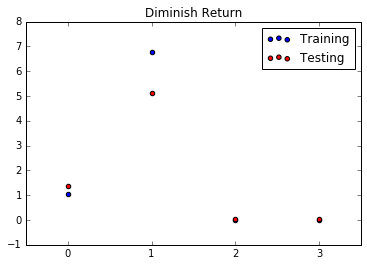

In [93]:
train_r = np.zeros(4)
test_r = np.zeros(4)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
for i,s in enumerate(feature_set):
    feature_set.remove(s)
    train_err1,test_err1=lr(feature_set,train_X,train_y,test_X,test_y)
    train_r[i] = train_err1-train_err
    test_r[i] = test_err1-test_err
    feature_set.add(s)
print train_r
plt.scatter(np.arange(4),train_r,label='Training')
plt.scatter(np.arange(4),test_r,label = 'Testing',c = 'red')
plt.xticks(np.arange(4),np.arange(4))
plt.title('Diminish Return')
plt.legend()
plt.show()

0.236320646978 6.438710545
0.236320646978 6.438710545
set([1, 2, 3]) 1.28700646465 7.81564696493
set([0, 2, 3]) 7.00910616417 11.5406985751
set([0, 1, 3]) 0.241625419303 6.47851202824
set([0, 1, 2]) 0.24322850122 6.48402769687
set([1, 3]) 1.30614251063 7.75610522605
set([0, 3]) 7.15532000215 11.7803813235
set([0, 1]) 0.244983359364 6.47939410906
set([1]) 1.31223134533 7.68994223996
set([0]) 7.17546956638 11.6718000862
[ 0.00530477  0.00335794  1.06724799] [ 2.  3.  0.]


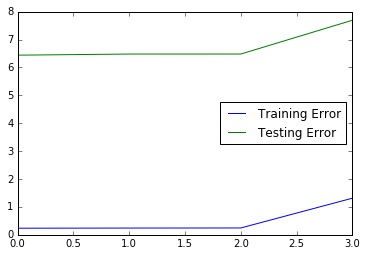

In [99]:
train_r = np.zeros(4)
test_r = np.zeros(4)
r = np.zeros(3)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
print train_err,test_err
train_r[0] = train_err
test_r[0] = test_err
removed = np.zeros(3)
for i in range(3):
    dr = 100
    f = 0
    for s in feature_set:
        feature_set.remove(s)
        train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
        print feature_set,train_err,test_err
        if train_err-train_r[i]<dr: 
            dr = train_err-train_r[i]
            train_r[i+1] = train_err
            test_r[i+1] = test_err
            f = s;
        feature_set.add(s)
    r[i] = train_r[i+1]-train_r[i]
    feature_set.remove(f)
    removed[i]=f
print r,removed
plt.plot(np.arange(4),train_r,label='Training Error')
plt.plot(np.arange(4),test_r,label = 'Testing Error')
plt.legend(loc='best')
plt.show()